In [1]:
from os import chdir
chdir('..')

In [2]:
# import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.relational import _LinePlotter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib notebook
sns.set(font_scale=1.1)
current_palette = sns.color_palette()

In [3]:
df = pd.read_csv('./test_fixtures/results/all_timings.csv')
df = df.replace('migloveholes', 'miglove')
df = df.replace('hiholes', 'hi')
df = df.replace('caholes', 'ca')
df_all_section = df[df.section == 'all']
df_all_poly_cgal = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal'])]
df_all_poly_cgal_spatialite = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal', 'spatialite'])]
df_pl = df[df.alg == 'polylidar']
df_pl_sec = df_pl[df_pl.section != 'all']
df.head()

,alg,holes,l2_norm,points,section,shape,time
0,polylidar,True,NaN,8000,delaunay,ca,4.945
1,polylidar,True,NaN,8000,delaunay,ca,3.618
2,polylidar,True,NaN,8000,delaunay,ca,3.520
3,polylidar,True,NaN,8000,delaunay,ca,3.350
4,polylidar,True,NaN,8000,delaunay,ca,3.713


In [4]:
def add_proper_legend(p, ax):
    p.legend='brief'
    p.add_legend_data(ax)
    legend_data = dict(p.legend_data)
    # Delete the parts of the legend we dont want
    for to_del in [True, False, 'alg', 'holes']:
        del legend_data[to_del]
    # Create the legend
    labels, handles = list(zip(*legend_data.items()))
    ax.legend(handles, labels)

def plot_time(df, df_inset, inset_axes=(0.75,0.35,.3,.25), inset_limits=(50000, 64000, 0, 500)):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
             sort=True, err_style="band", err_kws=None)
    
    palette = {'polylidar': current_palette[0], 'cgal': current_palette[1], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="time", hue="alg", style='holes',legend='brief', data=df, palette=palette, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    # Hacky way to create the legend that we want
    # have seaborn get the artist handles
    add_proper_legend(p, ax)


    ax.set_ylabel("time (ms)")
    ax.set_xlabel("# Points")
    ax.set_title('')
    # ax = g.facet_axis(0,0)
    ax.set_xlim([0, 70000])

    # Add inset zoomed in axes
    axins = ax.inset_axes(inset_axes)
    # axins = zoomed_inset_axes(ax,1.0,loc=1) # zoom=6
    x1,x2,y1,y2 = inset_limits
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)
    axins.set_xticks([])
    axins.set_yticks([0, 200, 400])
    axins.yaxis.tick_right()

    mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.3")
    sns.lineplot(x='points', y='time', hue='alg', style='holes', legend=False, data=df_inset, ax=axins)
    axins.set_xlabel('')
    axins.set_ylabel('')
    for spine in axins.spines.values():
        spine.set_edgecolor('0.3')
        
def plot_error(df, y_lim=[0, 0.12]):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
                        sort=True, err_style="band", err_kws=None)
    palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="l2_norm", hue="alg", style='holes', palette=palette, legend=False, data=df, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    add_proper_legend(p, ax)

    ax.set_title('')
    ax.set_ylabel(r'$L^2$ error')
    ax.set_xlabel("# Points")
    ax.set_ylim(y_lim)

    

# MI

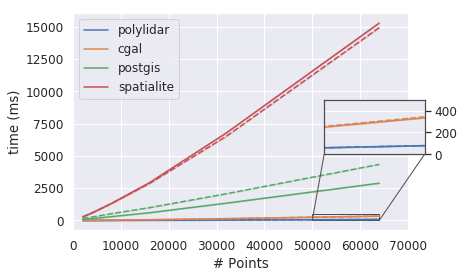

In [5]:
plt.close(plt.gcf())
df_mi = df_all_section[df_all_section['shape'].isin(['miglove'])]
df_mi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['miglove'])]
plot_time(df_mi, df_mi_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_mi.pdf', bbox_inches='tight')

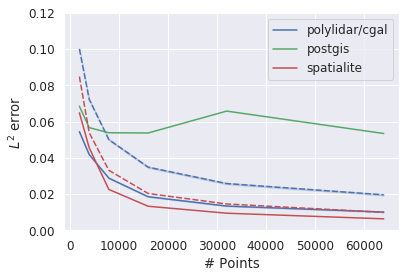

In [6]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_mi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_mi.pdf', bbox_inches='tight')
# g.set(yscale="log")

In [7]:
df_mi_means = df_mi.groupby(['points', 'alg'])[['time', 'l2_norm']].mean()
df_mi_means = df_mi_means.reset_index()
df_p = df_mi_means.pivot(index='alg', columns='points', values=['l2_norm']).round(3) * 100
df_p.reindex(["polylidar", "cgal", "postgis", 'spatialite'])

l2_norm                              
points       2000  4000  8000  16000 32000 64000
alg                                             
polylidar      7.8   5.7   4.0   2.7   2.0   1.5
cgal           7.7   5.7   3.9   2.6   1.9   1.5
postgis       15.2  14.1  13.0  13.9  14.4  13.9
spatialite     7.5   5.0   2.8   1.7   1.2   0.8

# CA

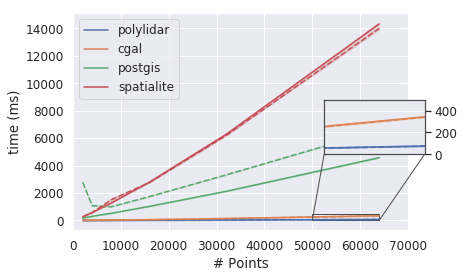

In [8]:
plt.close(plt.gcf())
df_ca = df_all_section[df_all_section['shape'].isin(['ca'])]
df_ca_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['ca'])]
plot_time(df_ca, df_ca_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_ca.pdf', bbox_inches='tight')

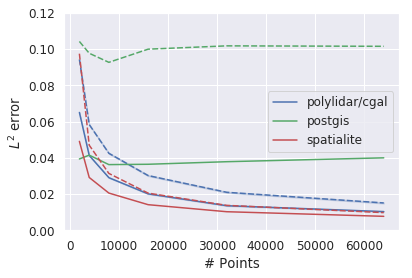

In [9]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_ca.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_ca.pdf', bbox_inches='tight')
# g.set(yscale="log")

# HI

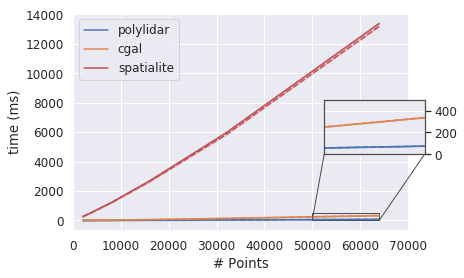

In [10]:
plt.close(plt.gcf())
df_hi = df_all_poly_cgal_spatialite[df_all_poly_cgal_spatialite['shape'].isin(['hi'])]
df_hi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['hi'])]
plot_time(df_hi, df_hi)

plt.savefig('assets/pics/compare_algs_time_inset_hi.pdf', bbox_inches='tight')

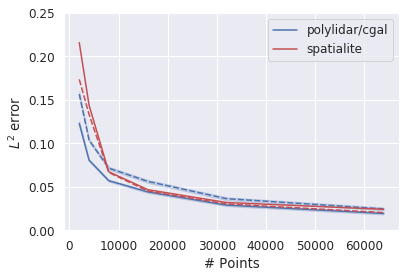

In [11]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_hi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal, y_lim=[0, 0.250])

plt.savefig('assets/pics/compare_algs_accuracy_hi.pdf', bbox_inches='tight')

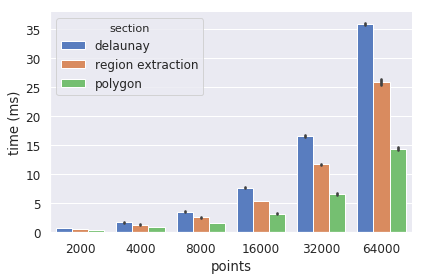

In [12]:
fig = plt.Figure((5,5))
df_pl_sec = df_pl_sec.replace('mesh', 'region extraction')
g = sns.catplot(x="points", y="time", hue="section", data=df_pl_sec, kind="bar", palette="muted",
                hue_order=["delaunay", "region extraction", "polygon"],  height=4, aspect=1.5, legend_out=False)

g.set_ylabels("time (ms)")
g.savefig('assets/pics/polylidar_decomposed.pdf')
# g.set(yscale="log")
# g.savefig("imgs/timing_results.pdf")

In [13]:
df_pl_sec_miglove = df_pl_sec[df_pl_sec['shape'] == 'miglove']

df_new = df_pl_sec_miglove.groupby([df_pl_sec_miglove['section'], df_pl_sec_miglove['points']]).mean()
df_new = df_new.reset_index()
df_delaunay = df_new[df_new['section'] == 'delaunay']
df_mesh = df_new[df_new['section'] == 'mesh']
df_polygon = df_new[df_new['section'] == 'polygon']

delaunay_diff = df_delaunay['time'].pct_change().reset_index()
mesh_diff = df_mesh['time'].pct_change().reset_index()
polygon_diff = df_polygon['time'].pct_change().reset_index()

values = []
names = ['delaunay_PctChange', 'mesh_PctChange', 'polygon_PctChange']
values.append(delaunay_diff.values[1:,1])
values.append(mesh_diff.values[1:, 1])
values.append(polygon_diff.values[1:, 1])

pd.DataFrame.from_items(zip(names, values))



/home/jeremy/miniconda3/envs/concave/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
